<a href="https://colab.research.google.com/github/Bkb-Med/weekly_sales__H_LSTM_MTS_forecasting/blob/main/weekly_sales__H_LSTM_MTS_forecasting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Forecasting weekly sales for given date and store number**



```
__author__: BOUKBAB M'hamed
__mail__: boukbab.med@gmail.com
```



In this notebook, subsequent to conducting an analysis of the given dataset, we propose the utilization of hierarchical LSTM models for the purpose of forecasting multivariate time series. The dataset comprises various types of variables, including datetime, categorical, and numeric. Our decision to investigate the dataset was driven by the fact that the data was chronologically recorded, with specific dates (day of the week) serving as the basis for this organization. Consequently, we identified the date as a pivotal component for analyzing the accompanying features.

Another notable consideration is that the data is distributed across multiple stores, implying that each store possesses its own contextual information. As a result, pertinent details from one store, such as sales income, could impact the sales of other stores. Therefore, amalgamating all the data might not yield a precise Machine Learning Model. Furthermore, certain latent store-related attributes, like product brand, could contribute to the sales of other stores.

To address these intricacies, we opted to construct hierarchical models. These models encompass a primary LSTM model that incorporates aggregated total sales based on weekly dates. Additionally, we computed the historical proportion attributed to each store. Complementing this is the creation of store-specific LSTM models, tailored to predict weekly sales for individual stores. Subsequently, we disaggregate the predictions based on historical proportions.

Our approach to building the Machine Learning model, which forecasts weekly sales for a specified date and store number, follows these steps:



In [ ]:
from google.colab import drive
drive.mount('/content/drive')
!git clone https://github.com/HUMANITICS/ml-test.git

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Cloning into 'ml-test'...
remote: Enumerating objects: 7, done.
remote: Counting objects: 100% (7/7), done.
remote: Compressing objects: 100% (6/6), done.
remote: Total 7 (delta 1), reused 7 (delta 1), pack-reused 0
Receiving objects: 100% (7/7), 121.77 KiB | 6.76 MiB/s, done.
Resolving deltas: 100% (1/1), done.


In [ ]:
cd ml-test/

/content/ml-test/ml-test


In [ ]:
import pandas as pd
import numpy as np
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from statsmodels.tsa.seasonal import seasonal_decompose
# Initialize the scaler
scaler = StandardScaler()

In [ ]:
main_data = pd.read_csv('stores_sales.csv')
main_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6435 entries, 0 to 6434
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   store         6435 non-null   int64  
 1   date          6435 non-null   object 
 2   weekly_sales  6435 non-null   float64
 3   holiday_flag  6435 non-null   int64  
 4   temperature   6435 non-null   float64
 5   fuel_Price    6435 non-null   float64
 6   cpi           6435 non-null   float64
 7   unemployment  6435 non-null   float64
dtypes: float64(5), int64(2), object(1)
memory usage: 402.3+ KB


In [ ]:
main_data.describe()

,store,weekly_sales,holiday_flag,temperature,fuel_Price,cpi,unemployment
count,6435.000000,6.435000e+03,6435.000000,6435.000000,6435.000000,6435.000000,6435.000000
mean,23.000000,1.046965e+06,0.069930,60.663782,3.358607,171.578394,7.999151
std,12.988182,5.643666e+05,0.255049,18.444933,0.459020,39.356712,1.875885
min,1.000000,2.099862e+05,0.000000,-2.060000,2.472000,126.064000,3.879000
25%,12.000000,5.533501e+05,0.000000,47.460000,2.933000,131.735000,6.891000
50%,23.000000,9.607460e+05,0.000000,62.670000,3.445000,182.616521,7.874000
75%,34.000000,1.420159e+06,0.000000,74.940000,3.735000,212.743293,8.622000
max,45.000000,3.818686e+06,1.000000,100.140000,4.468000,227.232807,14.313000




# 1.   Data engineering
in this step we aim to visualize and analyze the data through a monthly resampling approach. This is necessary because the initial dataset is condensed on a weekly basis. By shifting to monthly resampling, we aim to uncover potential correlations between different features in the dataset. Additionally, we examine the trends within the weekly sales component to gain valuable insights into its behavior over time.



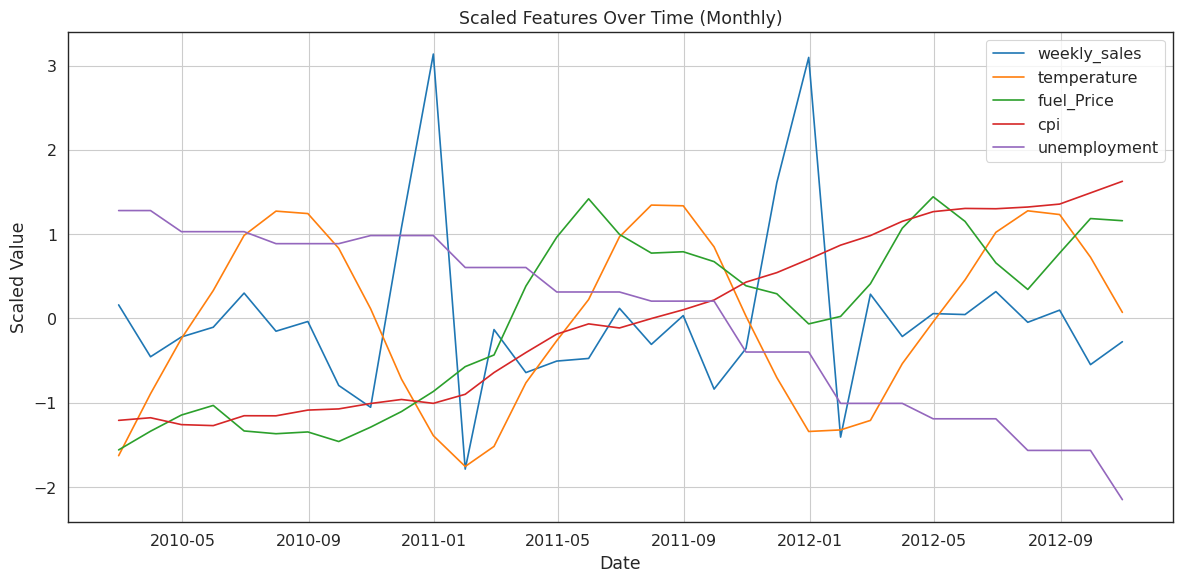

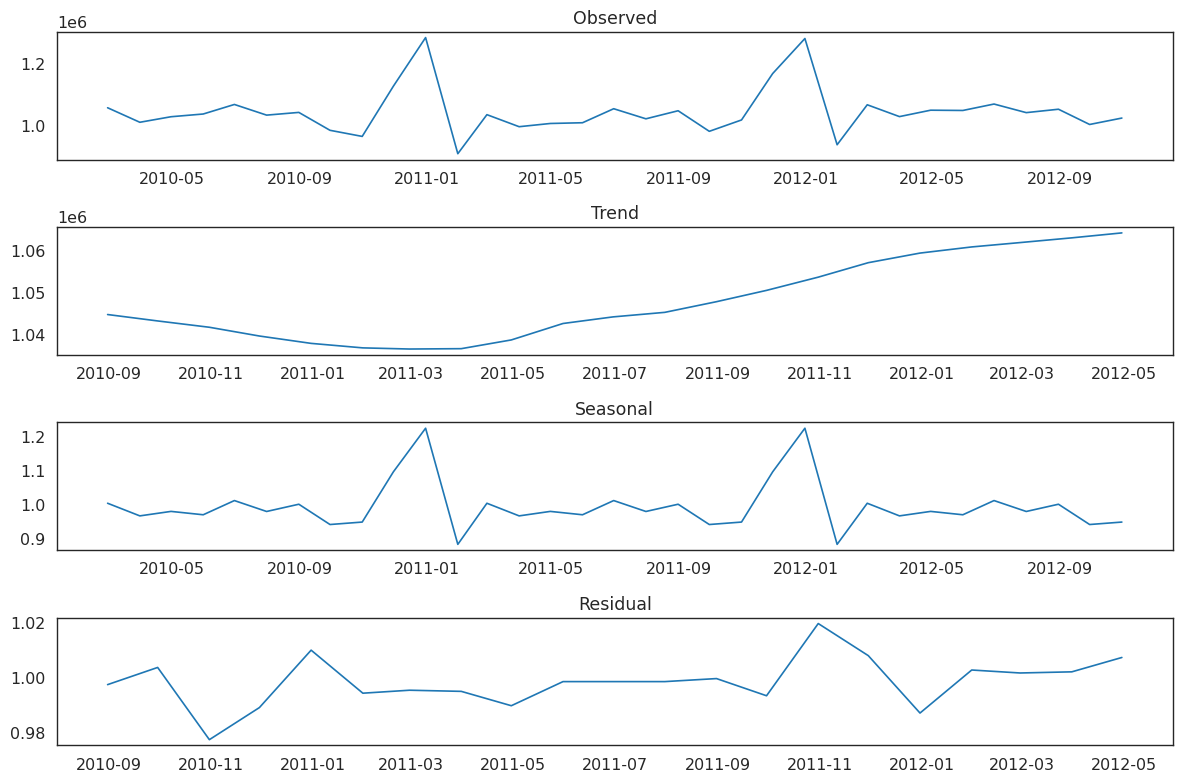

In [ ]:
main_data['date'] = pd.to_datetime(main_data['date'], dayfirst=True)
main_data.set_index('date', inplace=True)
sales_scaler = StandardScaler()
sales_scaled = sales_scaler.fit(main_data[['weekly_sales']])
features_to_scale = ['weekly_sales', 'temperature', 'fuel_Price', 'cpi', 'unemployment']
# Fit and transform the selected features
scaled_data = scaler.fit_transform(main_data[features_to_scale])
# Convert scaled_data back to a DataFrame
scaled_df = pd.DataFrame(scaled_data, columns=features_to_scale, index=main_data.index)
monthly_data = main_data[features_to_scale].resample('M').mean()
# Fit and transform the resampled data
scaled_monthly_data = scaler.fit_transform(monthly_data)
# Convert scaled_monthly_data back to a DataFrame
scaled_monthly_df = pd.DataFrame(scaled_monthly_data, columns=features_to_scale, index=monthly_data.index)
# Plotting the scaled monthly data
plt.figure(figsize=(12, 6))
for feature in features_to_scale:
    plt.plot(scaled_monthly_df.index, scaled_monthly_df[feature], label=feature)
plt.title('Scaled Features Over Time (Monthly)')
plt.xlabel('Date')
plt.ylabel('Scaled Value')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
monthly_sales = monthly_data['weekly_sales']
result = seasonal_decompose(monthly_sales, model='multiplicative')
# Increase the size of the decomposition plot
plt.figure(figsize=(12, 8))

# Plotting the components
plt.subplot(411)
plt.plot(result.observed)
plt.title('Observed')

plt.subplot(412)
plt.plot(result.trend)
plt.title('Trend')

plt.subplot(413)
plt.plot(result.seasonal)
plt.title('Seasonal')

plt.subplot(414)
plt.plot(result.resid)
plt.title('Residual')

plt.tight_layout()
plt.show()

In this particular phase, we focused on analyzing the correlation between weekly sales and various other features. Interestingly, our observations indicate that fuel prices have limited impact on weekly sales trends. However, a distinct pattern emerges with the unemployment rate, revealing its significance in influencing weekly sales.

Remarkably, our analysis highlights a negative correlation: as the unemployment rate decreases, there is a propensity for an increase in weekly sales. This implies that lower unemployment rates are associated with higher levels of weekly sales. In essence, the data suggests that the reduction in unemployment rates contributes to an uptick in the sales figures.

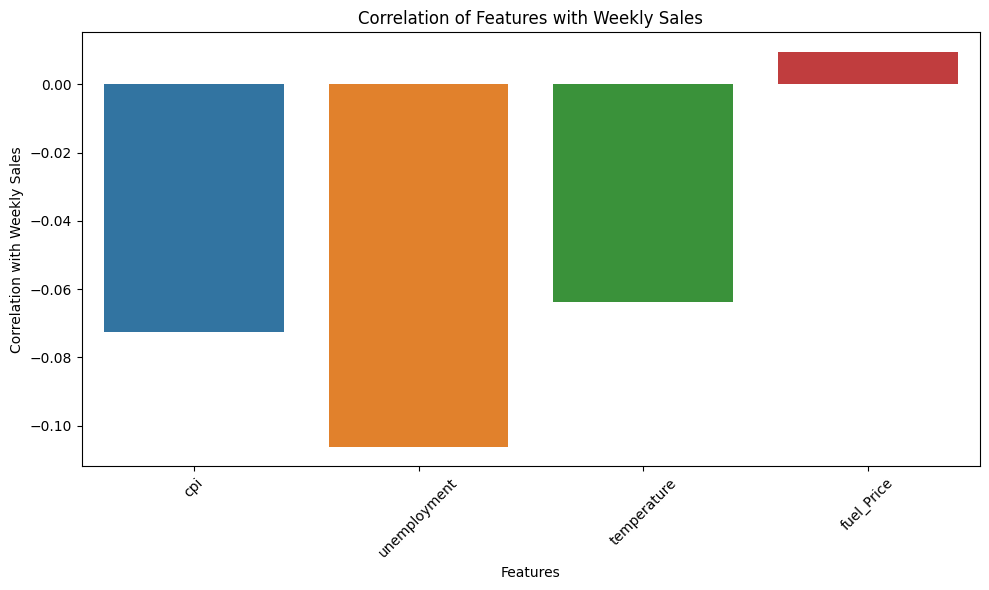

In [ ]:
import seaborn as sns

# Calculate the correlation matrix
correlation_matrix = main_data.corr()
# Extract correlations with "weekly_sales"
correlation_with_sales = correlation_matrix['weekly_sales'].sort_values(ascending=False)
included_features = ['cpi', 'unemployment','temperature', 'fuel_Price']
# Keep only the included features in correlation_with_sales
correlation_with_sales = correlation_with_sales[included_features]
# Plotting the correlation of features with "weekly_sales"
plt.figure(figsize=(10, 6))
sns.barplot(x=correlation_with_sales.index, y=correlation_with_sales.values)
plt.title('Correlation of Features with Weekly Sales')
plt.xlabel('Features')
plt.ylabel('Correlation with Weekly Sales')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In this section, we created visualizations comprising the monthly sales, rolling mean, and standard deviation. The aim was to assess the presence of a stationary regime within the data. The results indicate that the weekly sales series exhibits characteristics indicative of stationarity.

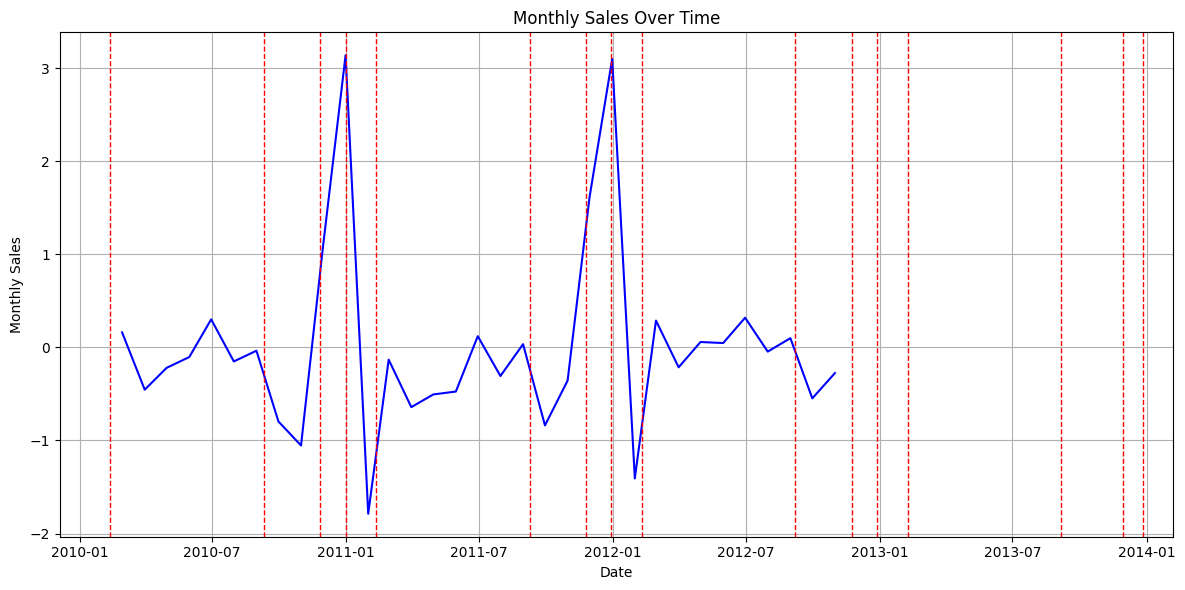

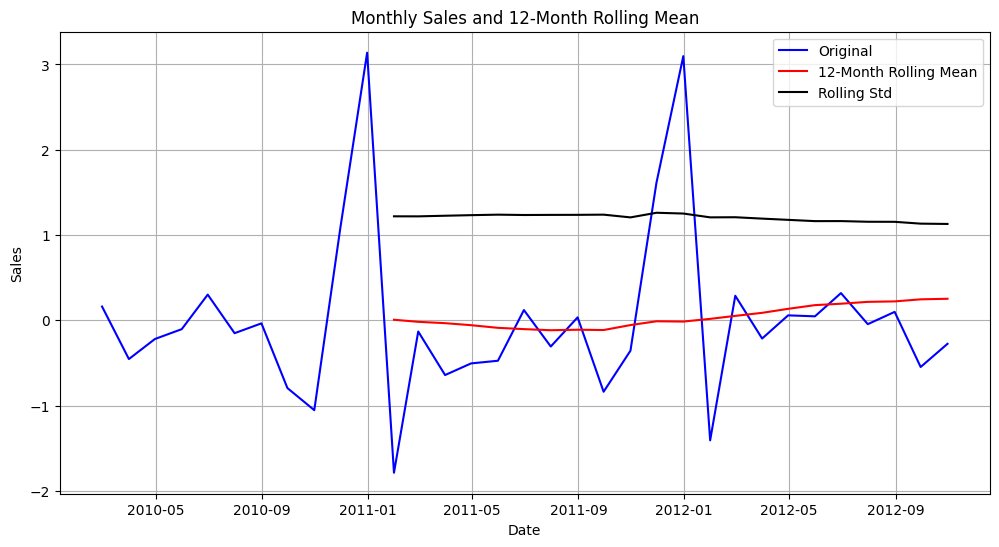

In [ ]:

# Plotting the resampled time series
plt.figure(figsize=(12, 6))
plt.plot(scaled_monthly_df['weekly_sales'], color='blue')
plt.title('Monthly Sales Over Time')
plt.xlabel('Date')
plt.ylabel('Monthly Sales')
plt.grid(True)
# Highlight holiday events
holiday_dates = ['2010-02-12', '2011-02-11', '2012-02-10', '2013-02-08',
                 '2010-09-10', '2011-09-09', '2012-09-07', '2013-09-06',
                 '2010-11-26', '2011-11-25', '2012-11-23', '2013-11-29',
                 '2010-12-31', '2011-12-30', '2012-12-28', '2013-12-27']
holiday_dates = [pd.to_datetime(date) for date in holiday_dates]
for holiday_date in holiday_dates:
    plt.axvline(x=holiday_date, color='red', linestyle='--', linewidth=1, label='Holiday')

plt.tight_layout()
plt.show()
# Plotting moving average
rolling_mean = scaled_monthly_df['weekly_sales'].rolling(window=12).mean()  # 12-month moving average
rolstd = scaled_monthly_df['weekly_sales'].rolling(window=12).std()
plt.figure(figsize=(12, 6))
plt.plot(scaled_monthly_df['weekly_sales'], color='blue', label='Original')
plt.plot(rolling_mean, color='red', label='12-Month Rolling Mean')
plt.plot(rolstd, color='black', label='Rolling Std')
plt.title('Monthly Sales and 12-Month Rolling Mean')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
len(main_data.store.value_counts())

45


#  a. Stationarity

In this segment, we assessed the stationarity of the remaining features. Our findings indicate that among these variables, only the weekly sales exhibit characteristics of stationarity. As a result, in our endeavor to construct a machine learning model, we will confine our investigation solely to the analysis of the weekly sales data.

In [ ]:
from statsmodels.tsa.stattools import adfuller
import pandas as pd

features = ['weekly_sales', 'temperature', 'cpi', 'unemployment']

def check_stationary(feature):
  #store_specific_data = main_data[main_data["store"]==store]
  # Perform Augmented Dickey-Fuller (ADF) test
  result = adfuller(scaled_monthly_df[feature], autolag='AIC')
  adf_statistic = result[0]
  p_value = result[1]
  critical_values = result[4]
  print(f'________{feature}____')
  print(f'ADF Statistic: {adf_statistic}')
  print(f'p-value: {p_value}')
  print('Critical Values:')
  for key, value in critical_values.items():
      print(f'  {key}: {value}')
  if p_value <= 0.05:
      print('Reject the null hypothesis. The time series is likely stationary.')
  else:
      print('Fail to reject the null hypothesis. The time series is likely non-stationary.')

for feature in features:
    check_stationary(feature)


________weekly_sales____
ADF Statistic: -5.779470939327907
p-value: 5.166156601697985e-07
Critical Values:
  1%: -3.653519805908203
  5%: -2.9572185644531253
  10%: -2.6175881640625
Reject the null hypothesis. The time series is likely stationary.
________temperature____
ADF Statistic: -0.0995528540436254
p-value: 0.9494830527549323
Critical Values:
  1%: -3.769732625845229
  5%: -3.005425537190083
  10%: -2.6425009917355373
Fail to reject the null hypothesis. The time series is likely non-stationary.
________cpi____
ADF Statistic: -0.5280369501298727
p-value: 0.8864281797039946
Critical Values:
  1%: -3.7238633119999998
  5%: -2.98648896
  10%: -2.6328004
Fail to reject the null hypothesis. The time series is likely non-stationary.
________unemployment____
ADF Statistic: -0.6956826217767695
p-value: 0.847864668912983
Critical Values:
  1%: -3.7529275211638033
  5%: -2.998499866852963
  10%: -2.6389669754253307
Fail to reject the null hypothesis. The time series is likely non-stationar


# 2.   Main LSTM Model

In this phase of the analysis, our focus was directed towards the computation of the cumulative sales encompassing all stores. This was accomplished by aggregating the data based on the date attribute. By grouping the data according to date, we were able to consolidate the sales figures across all stores into a comprehensive overview. This calculation and grouping process allows us to gain insights into the overall sales trend without regard to individual store distinctions.

(143, 2)


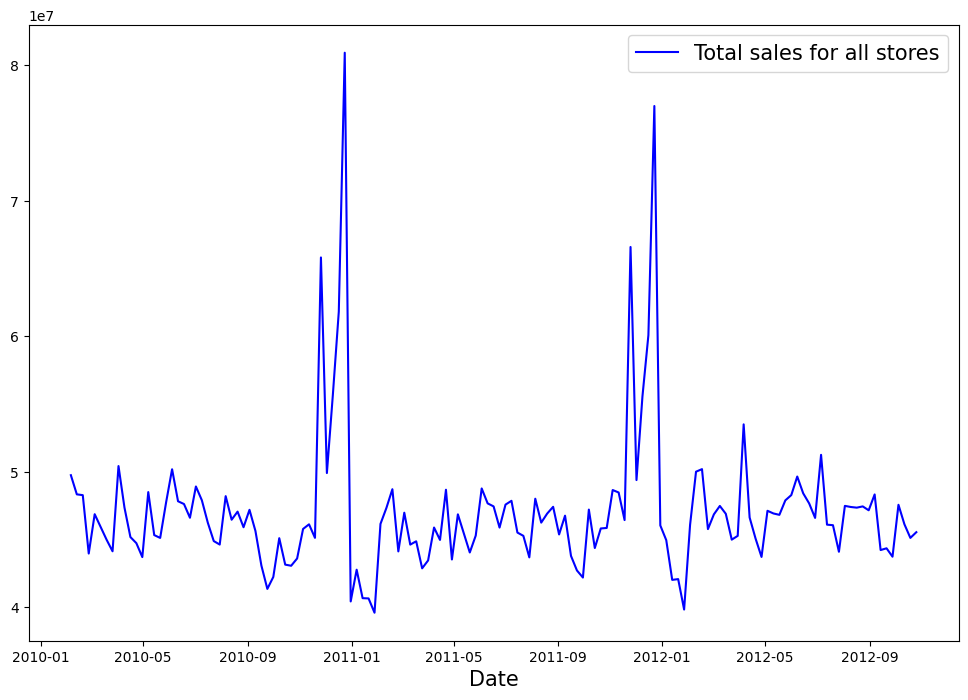

In [ ]:

total_df = pd.DataFrame()
# Aggregate the sales data to get total sales time series
total_sales_data = main_data.sort_values(by='date').groupby('date')['weekly_sales'].sum().reset_index()
total_df["total_sales_data"] = total_sales_data['weekly_sales']
print(np.shape(total_sales_data))
plt.figure(figsize=(12,8))
plt.plot(total_sales_data['date'], total_sales_data['weekly_sales'], 'b', label="Total sales for all stores")
plt.xlabel('Date', size=15)
plt.legend(fontsize=15)
plt.show();

# a - Building the model
In this section, we took the grouped data and augmented it by transforming it into daily sales records. Furthermore, we engaged in feature engineering, a process aimed at enhancing the dataset by incorporating additional pertinent attributes. These new features were meticulously selected to enrich the information available for training the LSTM (Long Short-Term Memory) model. This strategic augmentation and feature engineering collectively contribute to the model's ability to capture intricate patterns and dependencies within the data, ultimately bolstering its predictive capacity.

In [ ]:
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import *


total_sales_data.set_index('date', inplace=True)
total_sales_data = total_sales_data.resample("D").interpolate("linear")
scaler_total = StandardScaler()
#data normalization
normalized_total_sales = scaler_total.fit_transform(total_sales_data[['weekly_sales']])
normalized_total_df = pd.DataFrame()
normalized_total_df["date"] = total_sales_data.index
normalized_total_df.set_index('date', inplace=True)
normalized_total_df["normalized_total_sales"] = normalized_total_sales
num_lags = 3  # Number of lagged values to consider
for i in range(1, num_lags + 1):
    normalized_total_df[f'lag_{i}'] = normalized_total_df['normalized_total_sales'].shift(i)
# Moving Averages
window = 4  # Moving average window size
normalized_total_df['moving_avg'] = normalized_total_df['normalized_total_sales'].rolling(window=window).mean()
# Seasonality Features
normalized_total_df['month'] = normalized_total_df.index.month
normalized_total_df['quarter'] = normalized_total_df.index.quarter
normalized_total_df['day_of_week'] = normalized_total_df.index.dayofweek
normalized_total_df['week_of_month'] = normalized_total_df.index.map(lambda date: (date.day - 1) // 7 + 1)
normalized_total_df['week_of_year'] = normalized_total_df.index.map(lambda date: date.strftime('%U')).astype(int)
holiday_dates = ['2010-02-12', '2011-02-11', '2012-02-10', '2013-02-08',
                 '2010-09-10', '2011-09-09', '2012-09-07', '2013-09-06',
                 '2010-11-26', '2011-11-25', '2012-11-23', '2013-11-29',
                 '2010-12-31', '2011-12-30', '2012-12-28', '2013-12-27']
normalized_total_df['holiday_flag'] = normalized_total_df.index.isin(holiday_dates).astype(int)
#data cleaning
normalized_total_df = normalized_total_df.dropna()
#data splitting
train_size = int(len(normalized_total_df) * 0.85)
test_size = len(normalized_total_df) - train_size
train, test = normalized_total_df[0:train_size], normalized_total_df[train_size:len(normalized_total_df)]
train = train.drop(columns=['normalized_total_sales'])
test = test.drop(columns=['normalized_total_sales'])
Y_train , Y_test =  normalized_total_df['normalized_total_sales'][0:train_size], normalized_total_df['normalized_total_sales'][train_size:len(normalized_total_df)]
X_train = np.reshape(np.array(train), (train.shape[0],1, train.shape[1]))
X_test = np.reshape(np.array(test), (test.shape[0],1, test.shape[1]))

print(normalized_total_df.head())
print(np.shape(Y_train))
print(np.isnan(X_train).any())
print(np.isnan(Y_test).any())
print(np.isnan(X_test).any())
print(np.isnan(Y_train).any())

            normalized_total_sales     lag_1     lag_2     lag_3  moving_avg  \
date                                                                           
2010-02-08                0.422523  0.464476  0.506429  0.548382    0.485452   
2010-02-09                0.380571  0.422523  0.464476  0.506429    0.443500   
2010-02-10                0.338618  0.380571  0.422523  0.464476    0.401547   
2010-02-11                0.296665  0.338618  0.380571  0.422523    0.359594   
2010-02-12                0.254712  0.296665  0.338618  0.380571    0.317641   

            month  quarter  day_of_week  week_of_month  week_of_year  \
date                                                                   
2010-02-08      2        1            0              2             6   
2010-02-09      2        1            1              2             6   
2010-02-10      2        1            2              2             6   
2010-02-11      2        1            3              2             6   
2010-02

We train and save the main model of the total weekly sales

Epoch 1/30
7/7 [==============================] - 10s 301ms/step - loss: 1.0109 - rmse: 0.5741 - val_loss: 1.7651 - val_rmse: 0.7108
Epoch 2/30
7/7 [==============================] - 0s 19ms/step - loss: 0.9849 - rmse: 0.5658 - val_loss: 1.7198 - val_rmse: 0.7011
Epoch 3/30
7/7 [==============================] - 0s 24ms/step - loss: 0.9634 - rmse: 0.5649 - val_loss: 1.6600 - val_rmse: 0.6879
Epoch 4/30
7/7 [==============================] - 0s 18ms/step - loss: 0.9237 - rmse: 0.5543 - val_loss: 1.5790 - val_rmse: 0.6733
Epoch 5/30
7/7 [==============================] - 0s 22ms/step - loss: 0.8574 - rmse: 0.5298 - val_loss: 1.4742 - val_rmse: 0.6657
Epoch 6/30
7/7 [==============================] - 0s 20ms/step - loss: 0.7718 - rmse: 0.4950 - val_loss: 1.3311 - val_rmse: 0.6637
Epoch 7/30
7/7 [==============================] - 0s 19ms/step - loss: 0.6692 - rmse: 0.4710 - val_loss: 1.1248 - val_rmse: 0.6507
Epoch 8/30
7/7 [==============================] - 0s 20ms/step - loss: 0.5502 - r

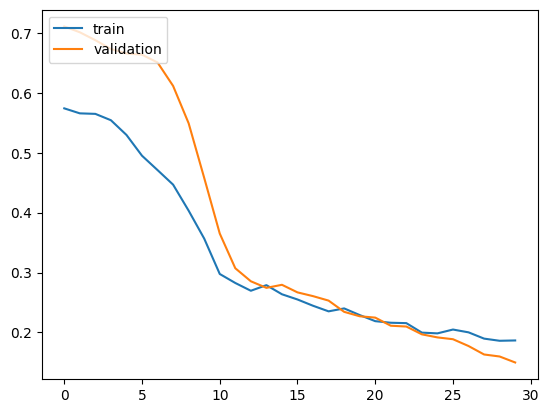

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 1, 128)            71168     
                                                                 
 dropout (Dropout)           (None, 1, 128)            0         
                                                                 
 lstm_1 (LSTM)               (None, 1, 64)             49408     
                                                                 
 dropout_1 (Dropout)         (None, 1, 64)             0         
                                                                 
 lstm_2 (LSTM)               (None, 32)                12416     
                                                                 
 dropout_2 (Dropout)         (None, 32)                0         
                                                                 
 dense (Dense)               (None, 1)                 3

In [ ]:
from keras import backend

def rmse(y_true, y_pred):
    return backend.sqrt(backend.mean(backend.square(y_pred - y_true), axis=-1))

model = Sequential()
model.add(LSTM(128, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(64, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(32))
model.add(Dropout(0.2))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam', metrics=[rmse])
#train the model
history = model.fit(X_train, Y_train, epochs=30, batch_size=100, verbose=1, shuffle=False, validation_split=0.2)
plt.plot(history.history['rmse'])
plt.plot(history.history['val_rmse'])
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
model.summary()
model_path = f'models/overall_model.h5'
model.save(model_path)

We plot the prediction to check the accuracy of the model

5/5 [==============================] - 0s 4ms/step
Train Root Mean Squared Error: 0.23887359189287266
Test Root Mean Squared Error: 0.09685610597534461


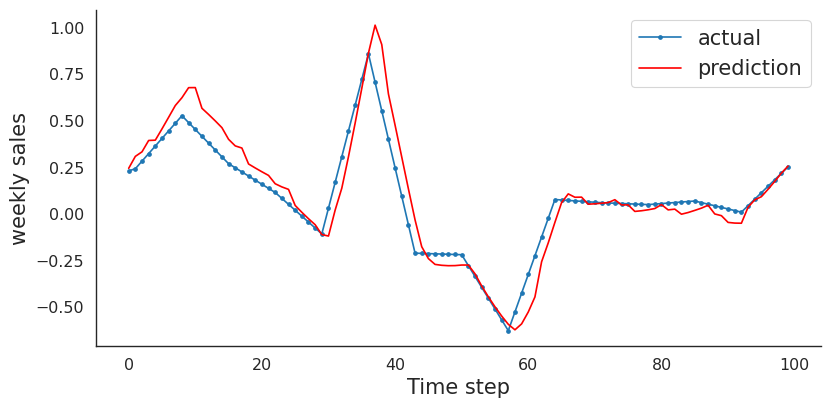

In [ ]:
from sklearn.metrics import mean_squared_error
import seaborn as sns
sns.set_context("paper", font_scale=1.3)
sns.set_style('white')
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)
test_rmse = np.sqrt(mean_squared_error(Y_test, test_predict))
train_rmse = np.sqrt(mean_squared_error(Y_train, train_predict))
print('Train Root Mean Squared Error:',train_rmse )
print('Test Root Mean Squared Error:', test_rmse)
aa=[x for x in range(100)]
plt.figure(figsize=(8,4))
plt.plot(aa, Y_test[:100], marker='.', label="actual")
plt.plot(aa, test_predict[:,0][:100], 'r', label="prediction")
# plt.tick_params(left=False, labelleft=True) #remove ticks
plt.tight_layout()
sns.despine(top=True)
plt.subplots_adjust(left=0.07)
plt.ylabel('weekly sales', size=15)
plt.xlabel('Time step', size=15)
plt.legend(fontsize=15)
plt.show();

In [ ]:
# here we calculate the historical proportions of each stores
data = pd.read_csv('stores_sales.csv')
data['date'] = pd.to_datetime(data['date'], dayfirst=True)
data.set_index('date', inplace=True)
store_count = len(main_data.store.value_counts())
historical_proportions = {}
for store in range(1, store_count + 1):
    store_data = data[data['store'] == store]
    total_sales = store_data['weekly_sales'].sum()
    historical_proportions[store] = total_sales / total_sales_data['weekly_sales'].sum()
print(historical_proportions)

{1: 0.004744628850112602, 2: 0.00587486948138937, 3: 0.0012285262313444613, 4: 0.006390318946205756, 5: 0.0009701553080618182, 6: 0.004773499931559467, 7: 0.0017407762624517317, 8: 0.002772312662253529, 9: 0.0016595157882947804, 10: 0.005794554700940434, 11: 0.004137903828005182, 12: 0.0030781506691053054, 13: 0.006112423537035274, 14: 0.006165377695155617, 15: 0.0019015328557692795, 16: 0.0015840636256589872, 17: 0.002726039412707318, 18: 0.003309139155282365, 19: 0.004408243462518207, 20: 0.006429867809945002, 21: 0.002306532054110849, 22: 0.00313763737500676, 23: 0.004240044990010992, 24: 0.004139039505431806, 25: 0.00215598799671536, 26: 0.0030595726873848955, 27: 0.0054156335220252524, 28: 0.004037655476572746, 29: 0.0016456988381320708, 30: 0.0013379702534703386, 31: 0.004258461931376595, 32: 0.0035588372834742276, 33: 0.0007927573491525344, 34: 0.002949350403633761, 35: 0.002805795387044038, 36: 0.0011394691344298559, 37: 0.0015830036693337633, 38: 0.0011767475250291349, 39: 0.0

# 3.   Store specific LSTM models
In this part we built a LSTM for each store, steps included are:


*   data scaling
*   data/features augmentation
*   data cleaning
*   spliting that data(training/testing)
*   training the models
*   saving each store specific model




tail        weekly_sales       lag_1       lag_2       lag_3  moving_avg  \
count  9.950000e+02  994.000000  993.000000  992.000000  992.000000   
mean  -2.056646e-15    0.000452    0.000890    0.001314   -0.000311   
std    1.000503e+00    1.000905    1.001314    1.001730    0.980962   
min   -1.740586e+00   -1.740586   -1.740586   -1.740586   -1.724141   
25%   -5.913107e-01   -0.591683   -0.592056   -0.593464   -0.579359   
50%   -1.603238e-01   -0.159472   -0.158620   -0.157727   -0.159981   
75%    3.809716e-01    0.382849    0.384727    0.385530    0.367435   
max    6.083081e+00    6.083081    6.083081    6.083081    5.427911   

            month     quarter  day_of_week  week_of_month  week_of_year  \
count  995.000000  995.000000   995.000000     995.000000    995.000000   
mean     6.388945    2.462312     3.001005       2.696482     25.853266   
std      3.234696    1.070614     2.000251       1.262498     14.089416   
min      1.000000    1.000000     0.000000       1.0000

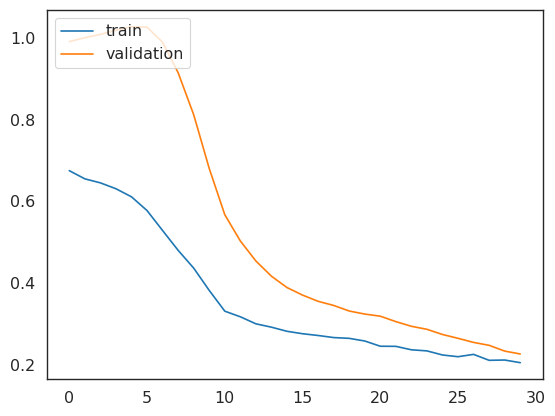

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_3 (LSTM)               (None, 1, 128)            71168     
                                                                 
 dropout_3 (Dropout)         (None, 1, 128)            0         
                                                                 
 lstm_4 (LSTM)               (None, 1, 64)             49408     
                                                                 
 dropout_4 (Dropout)         (None, 1, 64)             0         
                                                                 
 lstm_5 (LSTM)               (None, 32)                12416     
                                                                 
 dropout_5 (Dropout)         (None, 32)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                

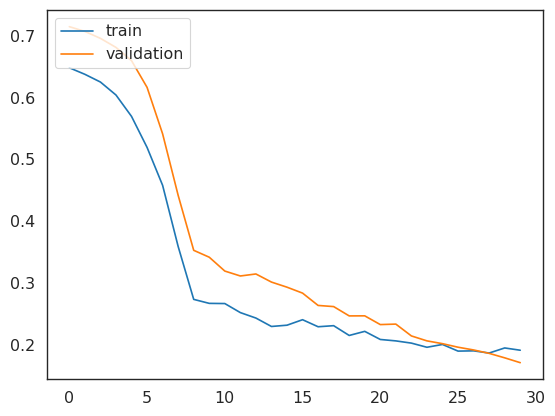

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_6 (LSTM)               (None, 1, 128)            71168     
                                                                 
 dropout_6 (Dropout)         (None, 1, 128)            0         
                                                                 
 lstm_7 (LSTM)               (None, 1, 64)             49408     
                                                                 
 dropout_7 (Dropout)         (None, 1, 64)             0         
                                                                 
 lstm_8 (LSTM)               (None, 32)                12416     
                                                                 
 dropout_8 (Dropout)         (None, 32)                0         
                                                                 
 dense_2 (Dense)             (None, 1)                

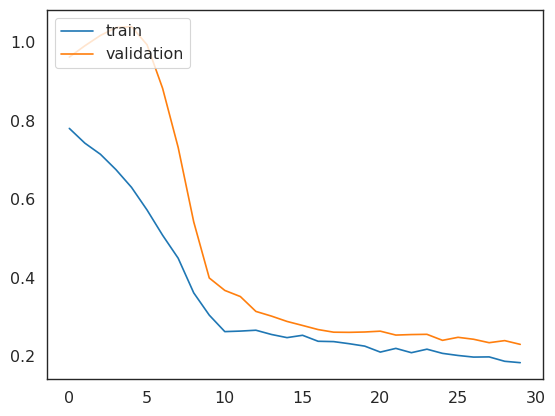

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_9 (LSTM)               (None, 1, 128)            71168     
                                                                 
 dropout_9 (Dropout)         (None, 1, 128)            0         
                                                                 
 lstm_10 (LSTM)              (None, 1, 64)             49408     
                                                                 
 dropout_10 (Dropout)        (None, 1, 64)             0         
                                                                 
 lstm_11 (LSTM)              (None, 32)                12416     
                                                                 
 dropout_11 (Dropout)        (None, 32)                0         
                                                                 
 dense_3 (Dense)             (None, 1)                

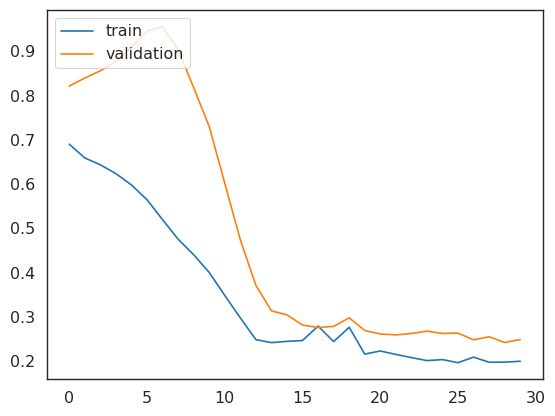

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_12 (LSTM)              (None, 1, 128)            71168     
                                                                 
 dropout_12 (Dropout)        (None, 1, 128)            0         
                                                                 
 lstm_13 (LSTM)              (None, 1, 64)             49408     
                                                                 
 dropout_13 (Dropout)        (None, 1, 64)             0         
                                                                 
 lstm_14 (LSTM)              (None, 32)                12416     
                                                                 
 dropout_14 (Dropout)        (None, 32)                0         
                                                                 
 dense_4 (Dense)             (None, 1)                

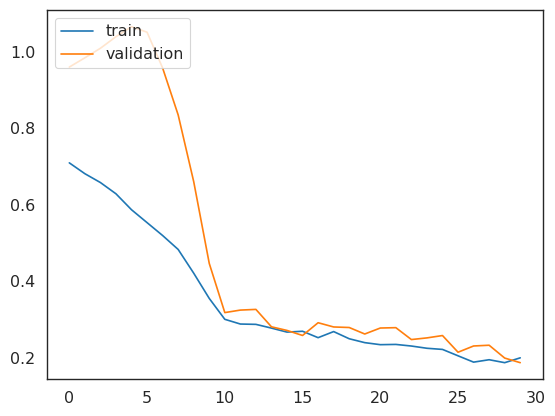

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_15 (LSTM)              (None, 1, 128)            71168     
                                                                 
 dropout_15 (Dropout)        (None, 1, 128)            0         
                                                                 
 lstm_16 (LSTM)              (None, 1, 64)             49408     
                                                                 
 dropout_16 (Dropout)        (None, 1, 64)             0         
                                                                 
 lstm_17 (LSTM)              (None, 32)                12416     
                                                                 
 dropout_17 (Dropout)        (None, 32)                0         
                                                                 
 dense_5 (Dense)             (None, 1)                

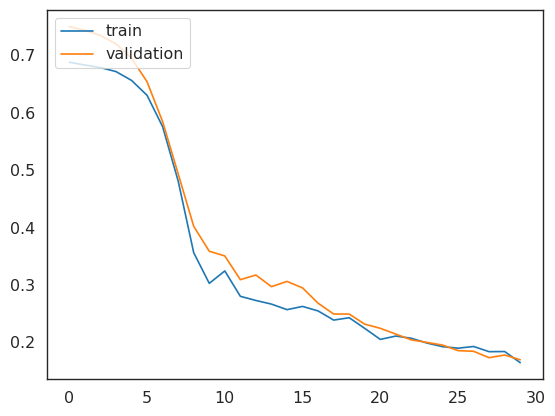

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_18 (LSTM)              (None, 1, 128)            71168     
                                                                 
 dropout_18 (Dropout)        (None, 1, 128)            0         
                                                                 
 lstm_19 (LSTM)              (None, 1, 64)             49408     
                                                                 
 dropout_19 (Dropout)        (None, 1, 64)             0         
                                                                 
 lstm_20 (LSTM)              (None, 32)                12416     
                                                                 
 dropout_20 (Dropout)        (None, 32)                0         
                                                                 
 dense_6 (Dense)             (None, 1)                

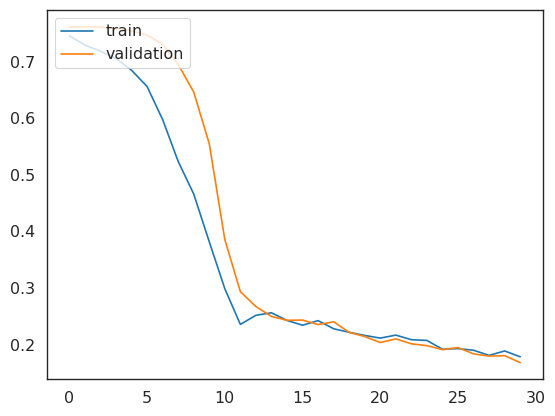

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_21 (LSTM)              (None, 1, 128)            71168     
                                                                 
 dropout_21 (Dropout)        (None, 1, 128)            0         
                                                                 
 lstm_22 (LSTM)              (None, 1, 64)             49408     
                                                                 
 dropout_22 (Dropout)        (None, 1, 64)             0         
                                                                 
 lstm_23 (LSTM)              (None, 32)                12416     
                                                                 
 dropout_23 (Dropout)        (None, 32)                0         
                                                                 
 dense_7 (Dense)             (None, 1)                

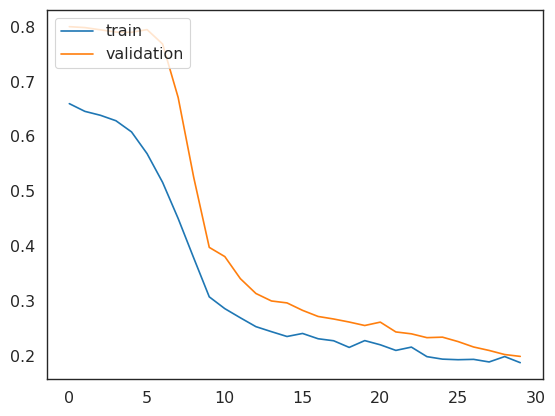

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_24 (LSTM)              (None, 1, 128)            71168     
                                                                 
 dropout_24 (Dropout)        (None, 1, 128)            0         
                                                                 
 lstm_25 (LSTM)              (None, 1, 64)             49408     
                                                                 
 dropout_25 (Dropout)        (None, 1, 64)             0         
                                                                 
 lstm_26 (LSTM)              (None, 32)                12416     
                                                                 
 dropout_26 (Dropout)        (None, 32)                0         
                                                                 
 dense_8 (Dense)             (None, 1)                

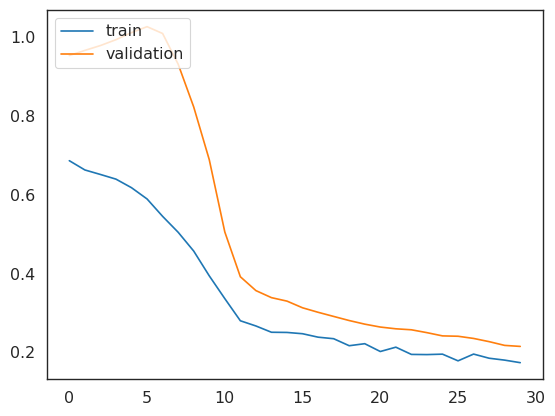

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_27 (LSTM)              (None, 1, 128)            71168     
                                                                 
 dropout_27 (Dropout)        (None, 1, 128)            0         
                                                                 
 lstm_28 (LSTM)              (None, 1, 64)             49408     
                                                                 
 dropout_28 (Dropout)        (None, 1, 64)             0         
                                                                 
 lstm_29 (LSTM)              (None, 32)                12416     
                                                                 
 dropout_29 (Dropout)        (None, 32)                0         
                                                                 
 dense_9 (Dense)             (None, 1)                

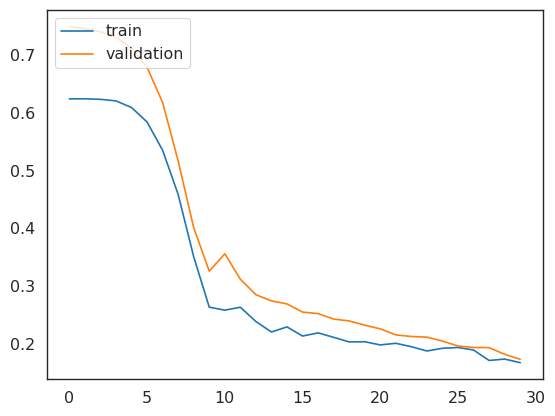

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_30 (LSTM)              (None, 1, 128)            71168     
                                                                 
 dropout_30 (Dropout)        (None, 1, 128)            0         
                                                                 
 lstm_31 (LSTM)              (None, 1, 64)             49408     
                                                                 
 dropout_31 (Dropout)        (None, 1, 64)             0         
                                                                 
 lstm_32 (LSTM)              (None, 32)                12416     
                                                                 
 dropout_32 (Dropout)        (None, 32)                0         
                                                                 
 dense_10 (Dense)            (None, 1)               

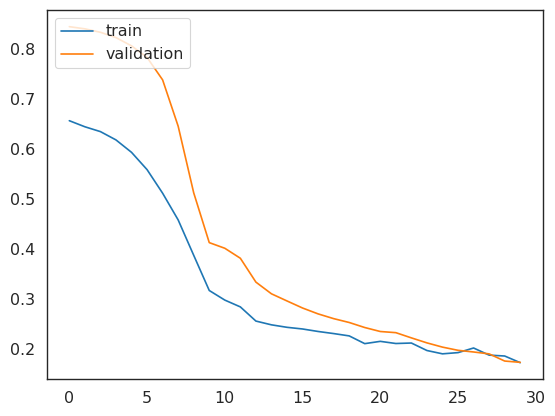

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_33 (LSTM)              (None, 1, 128)            71168     
                                                                 
 dropout_33 (Dropout)        (None, 1, 128)            0         
                                                                 
 lstm_34 (LSTM)              (None, 1, 64)             49408     
                                                                 
 dropout_34 (Dropout)        (None, 1, 64)             0         
                                                                 
 lstm_35 (LSTM)              (None, 32)                12416     
                                                                 
 dropout_35 (Dropout)        (None, 32)                0         
                                                                 
 dense_11 (Dense)            (None, 1)               

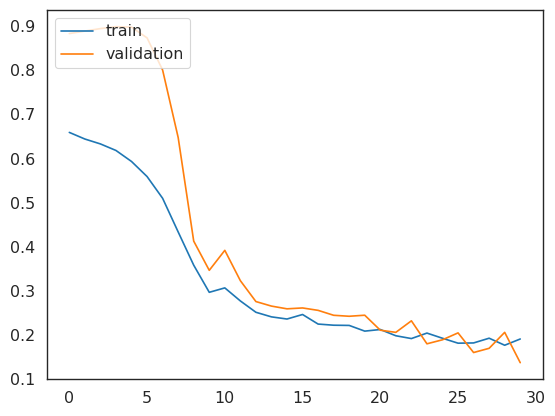

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_36 (LSTM)              (None, 1, 128)            71168     
                                                                 
 dropout_36 (Dropout)        (None, 1, 128)            0         
                                                                 
 lstm_37 (LSTM)              (None, 1, 64)             49408     
                                                                 
 dropout_37 (Dropout)        (None, 1, 64)             0         
                                                                 
 lstm_38 (LSTM)              (None, 32)                12416     
                                                                 
 dropout_38 (Dropout)        (None, 32)                0         
                                                                 
 dense_12 (Dense)            (None, 1)               

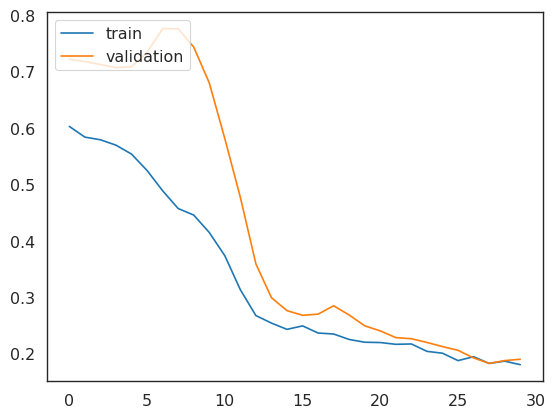

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_39 (LSTM)              (None, 1, 128)            71168     
                                                                 
 dropout_39 (Dropout)        (None, 1, 128)            0         
                                                                 
 lstm_40 (LSTM)              (None, 1, 64)             49408     
                                                                 
 dropout_40 (Dropout)        (None, 1, 64)             0         
                                                                 
 lstm_41 (LSTM)              (None, 32)                12416     
                                                                 
 dropout_41 (Dropout)        (None, 32)                0         
                                                                 
 dense_13 (Dense)            (None, 1)               

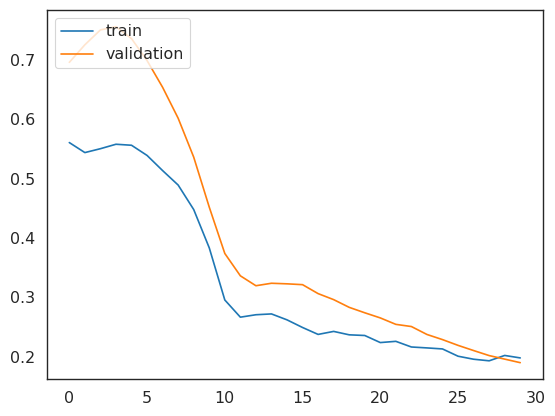

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_42 (LSTM)              (None, 1, 128)            71168     
                                                                 
 dropout_42 (Dropout)        (None, 1, 128)            0         
                                                                 
 lstm_43 (LSTM)              (None, 1, 64)             49408     
                                                                 
 dropout_43 (Dropout)        (None, 1, 64)             0         
                                                                 
 lstm_44 (LSTM)              (None, 32)                12416     
                                                                 
 dropout_44 (Dropout)        (None, 32)                0         
                                                                 
 dense_14 (Dense)            (None, 1)               

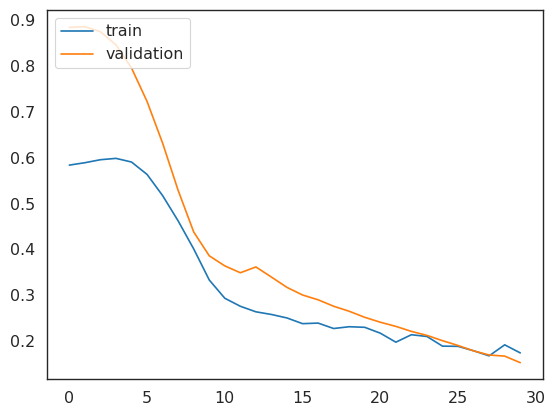

Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_45 (LSTM)              (None, 1, 128)            71168     
                                                                 
 dropout_45 (Dropout)        (None, 1, 128)            0         
                                                                 
 lstm_46 (LSTM)              (None, 1, 64)             49408     
                                                                 
 dropout_46 (Dropout)        (None, 1, 64)             0         
                                                                 
 lstm_47 (LSTM)              (None, 32)                12416     
                                                                 
 dropout_47 (Dropout)        (None, 32)                0         
                                                                 
 dense_15 (Dense)            (None, 1)               

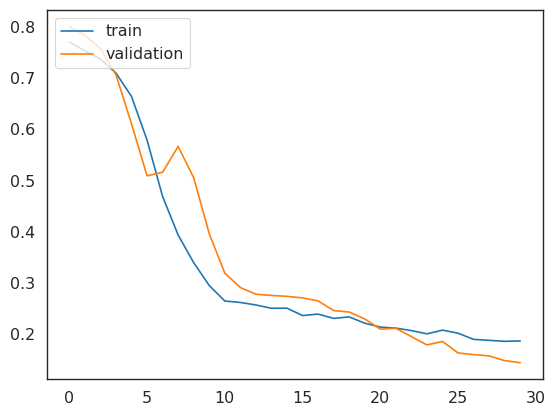

Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_48 (LSTM)              (None, 1, 128)            71168     
                                                                 
 dropout_48 (Dropout)        (None, 1, 128)            0         
                                                                 
 lstm_49 (LSTM)              (None, 1, 64)             49408     
                                                                 
 dropout_49 (Dropout)        (None, 1, 64)             0         
                                                                 
 lstm_50 (LSTM)              (None, 32)                12416     
                                                                 
 dropout_50 (Dropout)        (None, 32)                0         
                                                                 
 dense_16 (Dense)            (None, 1)               

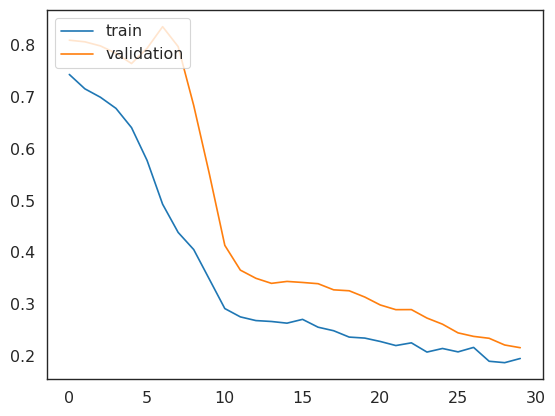

Model: "sequential_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_51 (LSTM)              (None, 1, 128)            71168     
                                                                 
 dropout_51 (Dropout)        (None, 1, 128)            0         
                                                                 
 lstm_52 (LSTM)              (None, 1, 64)             49408     
                                                                 
 dropout_52 (Dropout)        (None, 1, 64)             0         
                                                                 
 lstm_53 (LSTM)              (None, 32)                12416     
                                                                 
 dropout_53 (Dropout)        (None, 32)                0         
                                                                 
 dense_17 (Dense)            (None, 1)               

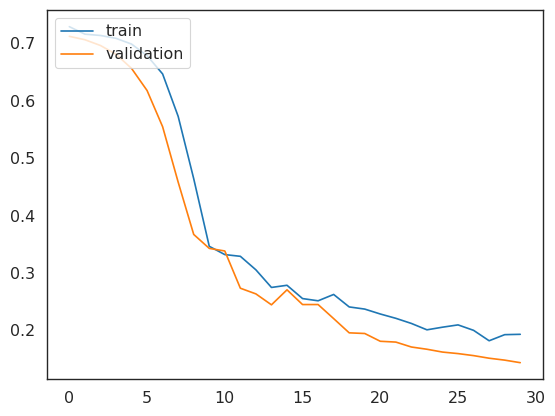

Model: "sequential_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_54 (LSTM)              (None, 1, 128)            71168     
                                                                 
 dropout_54 (Dropout)        (None, 1, 128)            0         
                                                                 
 lstm_55 (LSTM)              (None, 1, 64)             49408     
                                                                 
 dropout_55 (Dropout)        (None, 1, 64)             0         
                                                                 
 lstm_56 (LSTM)              (None, 32)                12416     
                                                                 
 dropout_56 (Dropout)        (None, 32)                0         
                                                                 
 dense_18 (Dense)            (None, 1)               

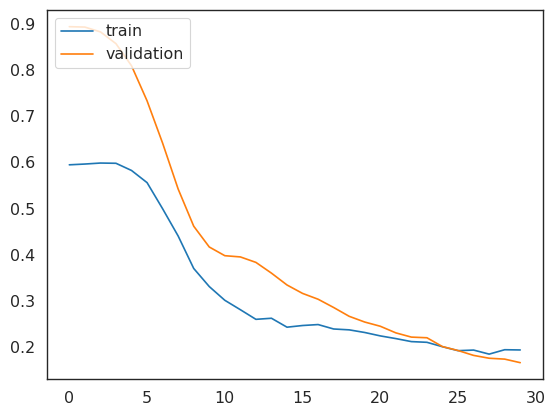

Model: "sequential_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_57 (LSTM)              (None, 1, 128)            71168     
                                                                 
 dropout_57 (Dropout)        (None, 1, 128)            0         
                                                                 
 lstm_58 (LSTM)              (None, 1, 64)             49408     
                                                                 
 dropout_58 (Dropout)        (None, 1, 64)             0         
                                                                 
 lstm_59 (LSTM)              (None, 32)                12416     
                                                                 
 dropout_59 (Dropout)        (None, 32)                0         
                                                                 
 dense_19 (Dense)            (None, 1)               

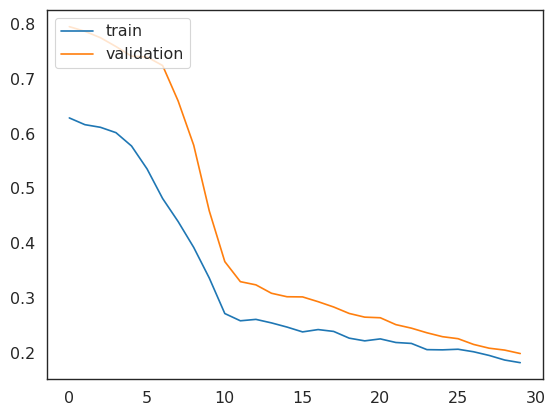

Model: "sequential_20"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_60 (LSTM)              (None, 1, 128)            71168     
                                                                 
 dropout_60 (Dropout)        (None, 1, 128)            0         
                                                                 
 lstm_61 (LSTM)              (None, 1, 64)             49408     
                                                                 
 dropout_61 (Dropout)        (None, 1, 64)             0         
                                                                 
 lstm_62 (LSTM)              (None, 32)                12416     
                                                                 
 dropout_62 (Dropout)        (None, 32)                0         
                                                                 
 dense_20 (Dense)            (None, 1)               

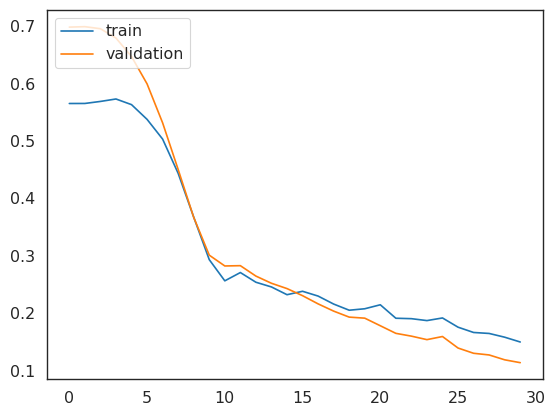

Model: "sequential_21"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_63 (LSTM)              (None, 1, 128)            71168     
                                                                 
 dropout_63 (Dropout)        (None, 1, 128)            0         
                                                                 
 lstm_64 (LSTM)              (None, 1, 64)             49408     
                                                                 
 dropout_64 (Dropout)        (None, 1, 64)             0         
                                                                 
 lstm_65 (LSTM)              (None, 32)                12416     
                                                                 
 dropout_65 (Dropout)        (None, 32)                0         
                                                                 
 dense_21 (Dense)            (None, 1)               

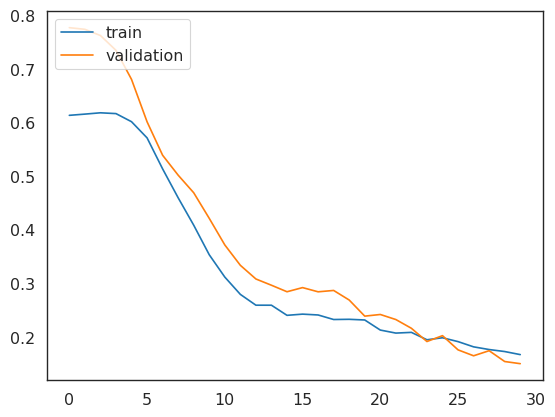

Model: "sequential_22"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_66 (LSTM)              (None, 1, 128)            71168     
                                                                 
 dropout_66 (Dropout)        (None, 1, 128)            0         
                                                                 
 lstm_67 (LSTM)              (None, 1, 64)             49408     
                                                                 
 dropout_67 (Dropout)        (None, 1, 64)             0         
                                                                 
 lstm_68 (LSTM)              (None, 32)                12416     
                                                                 
 dropout_68 (Dropout)        (None, 32)                0         
                                                                 
 dense_22 (Dense)            (None, 1)               

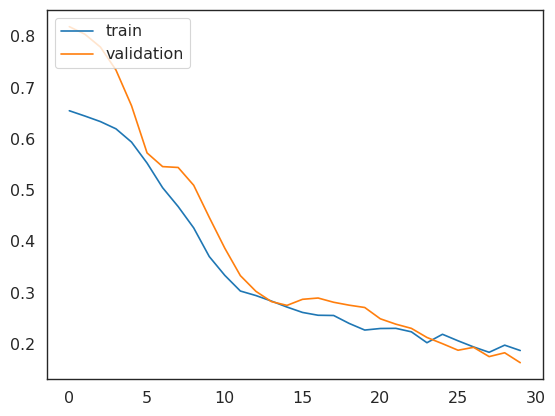

Model: "sequential_23"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_69 (LSTM)              (None, 1, 128)            71168     
                                                                 
 dropout_69 (Dropout)        (None, 1, 128)            0         
                                                                 
 lstm_70 (LSTM)              (None, 1, 64)             49408     
                                                                 
 dropout_70 (Dropout)        (None, 1, 64)             0         
                                                                 
 lstm_71 (LSTM)              (None, 32)                12416     
                                                                 
 dropout_71 (Dropout)        (None, 32)                0         
                                                                 
 dense_23 (Dense)            (None, 1)               

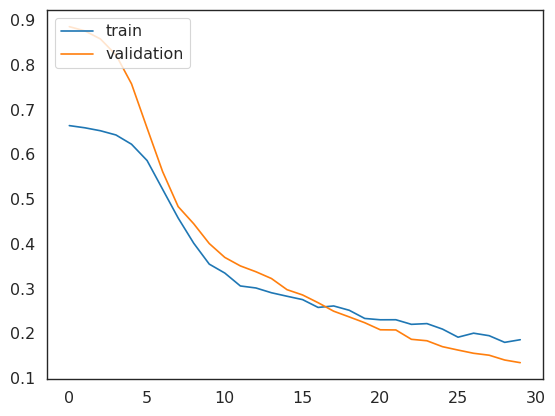

Model: "sequential_24"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_72 (LSTM)              (None, 1, 128)            71168     
                                                                 
 dropout_72 (Dropout)        (None, 1, 128)            0         
                                                                 
 lstm_73 (LSTM)              (None, 1, 64)             49408     
                                                                 
 dropout_73 (Dropout)        (None, 1, 64)             0         
                                                                 
 lstm_74 (LSTM)              (None, 32)                12416     
                                                                 
 dropout_74 (Dropout)        (None, 32)                0         
                                                                 
 dense_24 (Dense)            (None, 1)               

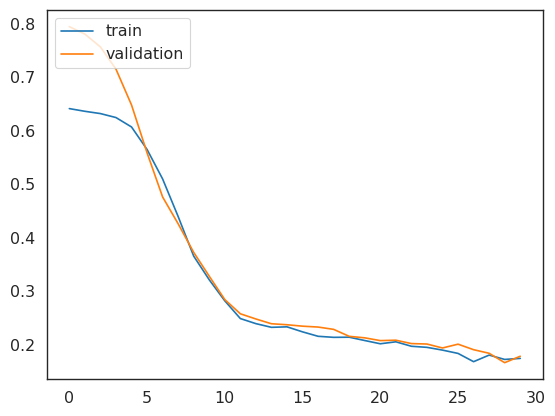

Model: "sequential_25"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_75 (LSTM)              (None, 1, 128)            71168     
                                                                 
 dropout_75 (Dropout)        (None, 1, 128)            0         
                                                                 
 lstm_76 (LSTM)              (None, 1, 64)             49408     
                                                                 
 dropout_76 (Dropout)        (None, 1, 64)             0         
                                                                 
 lstm_77 (LSTM)              (None, 32)                12416     
                                                                 
 dropout_77 (Dropout)        (None, 32)                0         
                                                                 
 dense_25 (Dense)            (None, 1)               

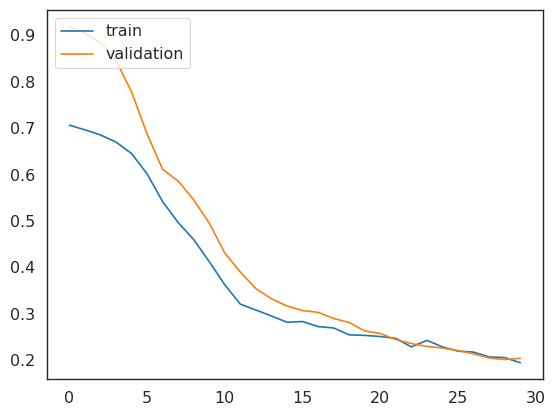

Model: "sequential_26"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_78 (LSTM)              (None, 1, 128)            71168     
                                                                 
 dropout_78 (Dropout)        (None, 1, 128)            0         
                                                                 
 lstm_79 (LSTM)              (None, 1, 64)             49408     
                                                                 
 dropout_79 (Dropout)        (None, 1, 64)             0         
                                                                 
 lstm_80 (LSTM)              (None, 32)                12416     
                                                                 
 dropout_80 (Dropout)        (None, 32)                0         
                                                                 
 dense_26 (Dense)            (None, 1)               

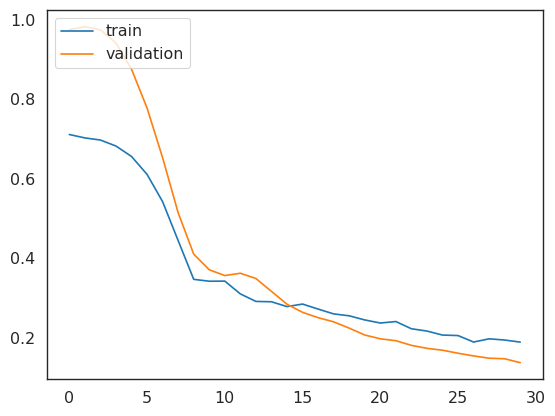

Model: "sequential_27"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_81 (LSTM)              (None, 1, 128)            71168     
                                                                 
 dropout_81 (Dropout)        (None, 1, 128)            0         
                                                                 
 lstm_82 (LSTM)              (None, 1, 64)             49408     
                                                                 
 dropout_82 (Dropout)        (None, 1, 64)             0         
                                                                 
 lstm_83 (LSTM)              (None, 32)                12416     
                                                                 
 dropout_83 (Dropout)        (None, 32)                0         
                                                                 
 dense_27 (Dense)            (None, 1)               

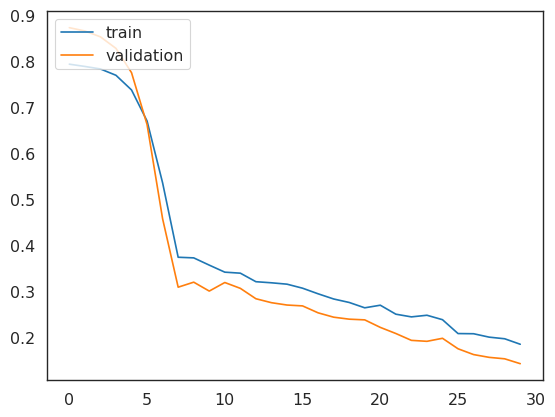

Model: "sequential_28"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_84 (LSTM)              (None, 1, 128)            71168     
                                                                 
 dropout_84 (Dropout)        (None, 1, 128)            0         
                                                                 
 lstm_85 (LSTM)              (None, 1, 64)             49408     
                                                                 
 dropout_85 (Dropout)        (None, 1, 64)             0         
                                                                 
 lstm_86 (LSTM)              (None, 32)                12416     
                                                                 
 dropout_86 (Dropout)        (None, 32)                0         
                                                                 
 dense_28 (Dense)            (None, 1)               

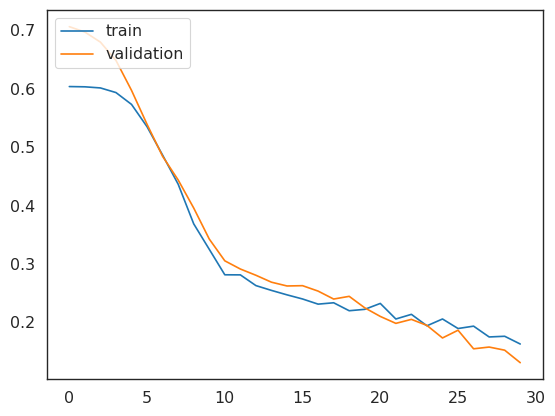

Model: "sequential_29"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_87 (LSTM)              (None, 1, 128)            71168     
                                                                 
 dropout_87 (Dropout)        (None, 1, 128)            0         
                                                                 
 lstm_88 (LSTM)              (None, 1, 64)             49408     
                                                                 
 dropout_88 (Dropout)        (None, 1, 64)             0         
                                                                 
 lstm_89 (LSTM)              (None, 32)                12416     
                                                                 
 dropout_89 (Dropout)        (None, 32)                0         
                                                                 
 dense_29 (Dense)            (None, 1)               

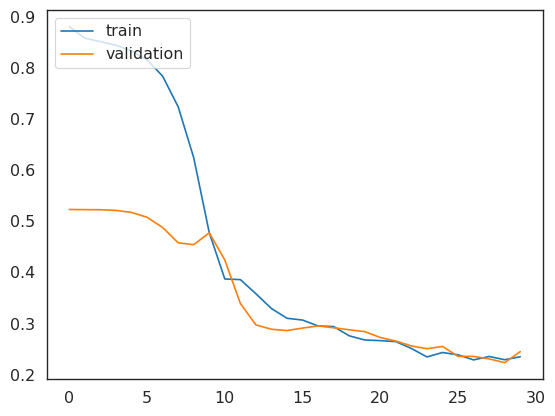

Model: "sequential_30"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_90 (LSTM)              (None, 1, 128)            71168     
                                                                 
 dropout_90 (Dropout)        (None, 1, 128)            0         
                                                                 
 lstm_91 (LSTM)              (None, 1, 64)             49408     
                                                                 
 dropout_91 (Dropout)        (None, 1, 64)             0         
                                                                 
 lstm_92 (LSTM)              (None, 32)                12416     
                                                                 
 dropout_92 (Dropout)        (None, 32)                0         
                                                                 
 dense_30 (Dense)            (None, 1)               

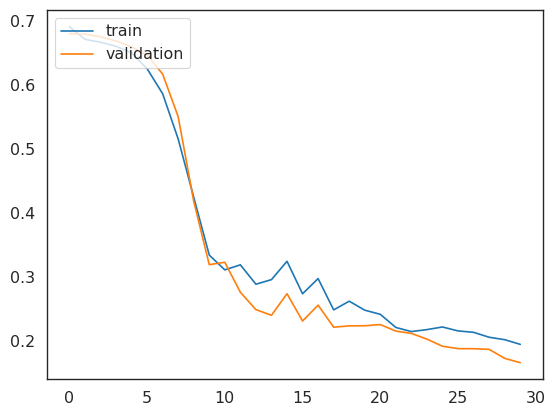

Model: "sequential_31"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_93 (LSTM)              (None, 1, 128)            71168     
                                                                 
 dropout_93 (Dropout)        (None, 1, 128)            0         
                                                                 
 lstm_94 (LSTM)              (None, 1, 64)             49408     
                                                                 
 dropout_94 (Dropout)        (None, 1, 64)             0         
                                                                 
 lstm_95 (LSTM)              (None, 32)                12416     
                                                                 
 dropout_95 (Dropout)        (None, 32)                0         
                                                                 
 dense_31 (Dense)            (None, 1)               

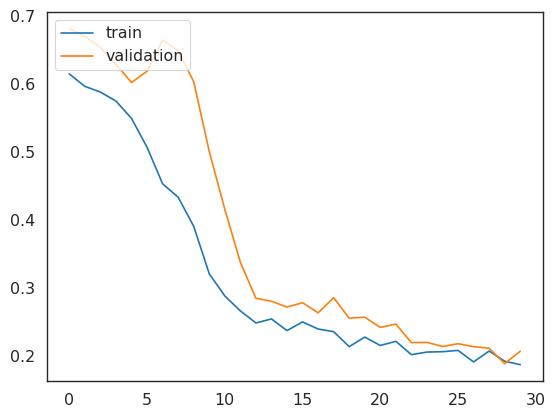

Model: "sequential_32"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_96 (LSTM)              (None, 1, 128)            71168     
                                                                 
 dropout_96 (Dropout)        (None, 1, 128)            0         
                                                                 
 lstm_97 (LSTM)              (None, 1, 64)             49408     
                                                                 
 dropout_97 (Dropout)        (None, 1, 64)             0         
                                                                 
 lstm_98 (LSTM)              (None, 32)                12416     
                                                                 
 dropout_98 (Dropout)        (None, 32)                0         
                                                                 
 dense_32 (Dense)            (None, 1)               

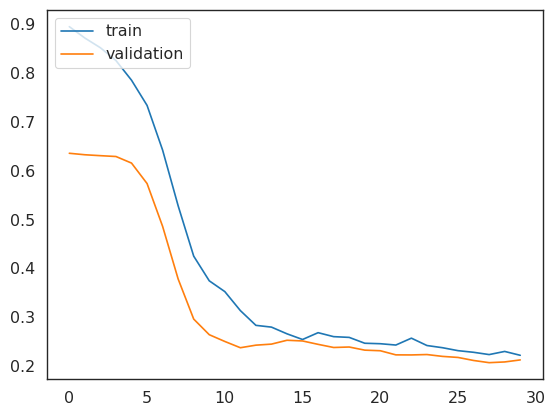

Model: "sequential_33"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_99 (LSTM)              (None, 1, 128)            71168     
                                                                 
 dropout_99 (Dropout)        (None, 1, 128)            0         
                                                                 
 lstm_100 (LSTM)             (None, 1, 64)             49408     
                                                                 
 dropout_100 (Dropout)       (None, 1, 64)             0         
                                                                 
 lstm_101 (LSTM)             (None, 32)                12416     
                                                                 
 dropout_101 (Dropout)       (None, 32)                0         
                                                                 
 dense_33 (Dense)            (None, 1)               

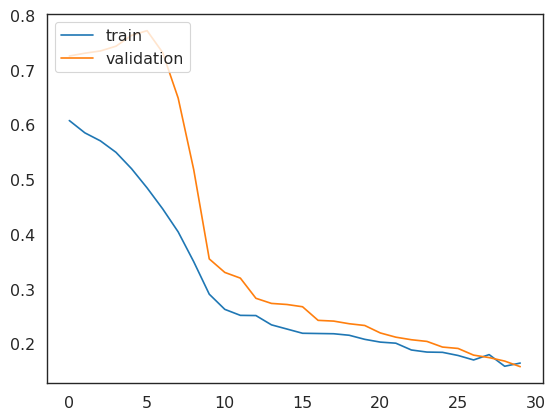

Model: "sequential_34"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_102 (LSTM)             (None, 1, 128)            71168     
                                                                 
 dropout_102 (Dropout)       (None, 1, 128)            0         
                                                                 
 lstm_103 (LSTM)             (None, 1, 64)             49408     
                                                                 
 dropout_103 (Dropout)       (None, 1, 64)             0         
                                                                 
 lstm_104 (LSTM)             (None, 32)                12416     
                                                                 
 dropout_104 (Dropout)       (None, 32)                0         
                                                                 
 dense_34 (Dense)            (None, 1)               

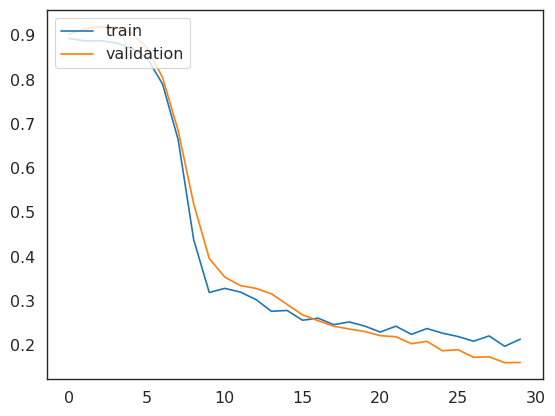

Model: "sequential_35"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_105 (LSTM)             (None, 1, 128)            71168     
                                                                 
 dropout_105 (Dropout)       (None, 1, 128)            0         
                                                                 
 lstm_106 (LSTM)             (None, 1, 64)             49408     
                                                                 
 dropout_106 (Dropout)       (None, 1, 64)             0         
                                                                 
 lstm_107 (LSTM)             (None, 32)                12416     
                                                                 
 dropout_107 (Dropout)       (None, 32)                0         
                                                                 
 dense_35 (Dense)            (None, 1)               

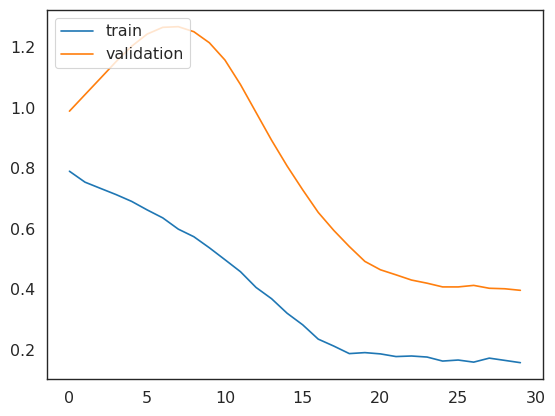

Model: "sequential_36"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_108 (LSTM)             (None, 1, 128)            71168     
                                                                 
 dropout_108 (Dropout)       (None, 1, 128)            0         
                                                                 
 lstm_109 (LSTM)             (None, 1, 64)             49408     
                                                                 
 dropout_109 (Dropout)       (None, 1, 64)             0         
                                                                 
 lstm_110 (LSTM)             (None, 32)                12416     
                                                                 
 dropout_110 (Dropout)       (None, 32)                0         
                                                                 
 dense_36 (Dense)            (None, 1)               

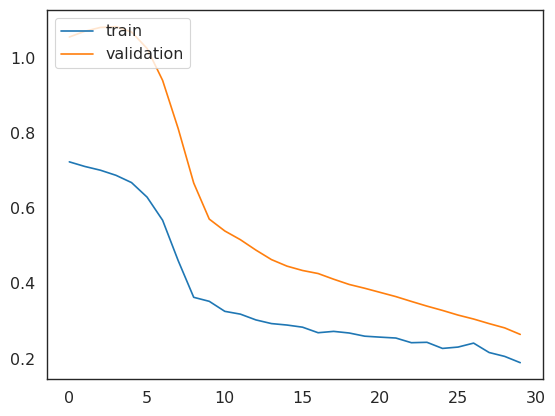

Model: "sequential_37"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_111 (LSTM)             (None, 1, 128)            71168     
                                                                 
 dropout_111 (Dropout)       (None, 1, 128)            0         
                                                                 
 lstm_112 (LSTM)             (None, 1, 64)             49408     
                                                                 
 dropout_112 (Dropout)       (None, 1, 64)             0         
                                                                 
 lstm_113 (LSTM)             (None, 32)                12416     
                                                                 
 dropout_113 (Dropout)       (None, 32)                0         
                                                                 
 dense_37 (Dense)            (None, 1)               

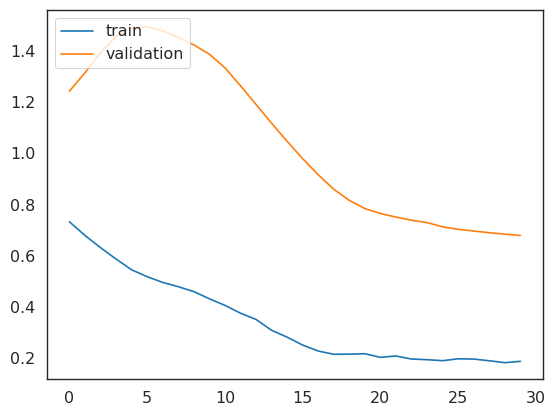

Model: "sequential_38"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_114 (LSTM)             (None, 1, 128)            71168     
                                                                 
 dropout_114 (Dropout)       (None, 1, 128)            0         
                                                                 
 lstm_115 (LSTM)             (None, 1, 64)             49408     
                                                                 
 dropout_115 (Dropout)       (None, 1, 64)             0         
                                                                 
 lstm_116 (LSTM)             (None, 32)                12416     
                                                                 
 dropout_116 (Dropout)       (None, 32)                0         
                                                                 
 dense_38 (Dense)            (None, 1)               

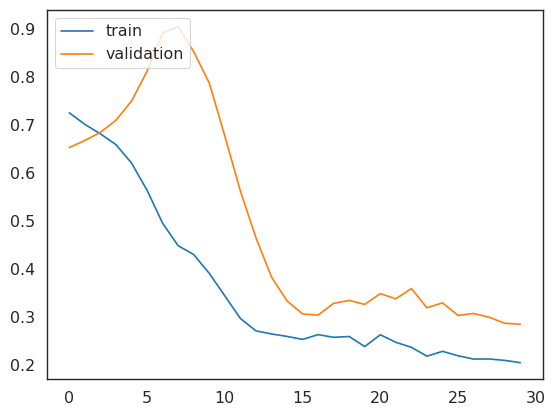

Model: "sequential_39"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_117 (LSTM)             (None, 1, 128)            71168     
                                                                 
 dropout_117 (Dropout)       (None, 1, 128)            0         
                                                                 
 lstm_118 (LSTM)             (None, 1, 64)             49408     
                                                                 
 dropout_118 (Dropout)       (None, 1, 64)             0         
                                                                 
 lstm_119 (LSTM)             (None, 32)                12416     
                                                                 
 dropout_119 (Dropout)       (None, 32)                0         
                                                                 
 dense_39 (Dense)            (None, 1)               

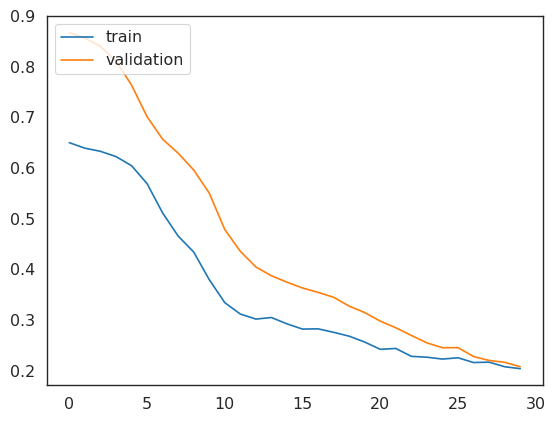

Model: "sequential_40"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_120 (LSTM)             (None, 1, 128)            71168     
                                                                 
 dropout_120 (Dropout)       (None, 1, 128)            0         
                                                                 
 lstm_121 (LSTM)             (None, 1, 64)             49408     
                                                                 
 dropout_121 (Dropout)       (None, 1, 64)             0         
                                                                 
 lstm_122 (LSTM)             (None, 32)                12416     
                                                                 
 dropout_122 (Dropout)       (None, 32)                0         
                                                                 
 dense_40 (Dense)            (None, 1)               

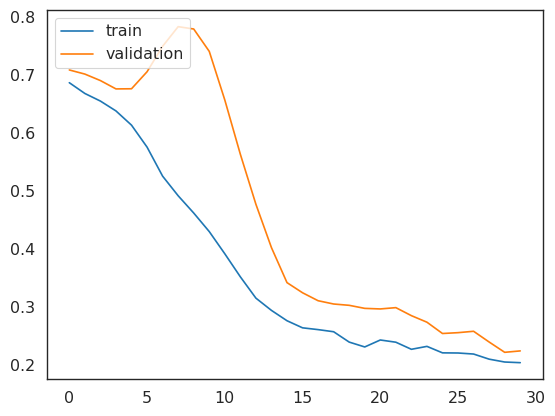

Model: "sequential_41"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_123 (LSTM)             (None, 1, 128)            71168     
                                                                 
 dropout_123 (Dropout)       (None, 1, 128)            0         
                                                                 
 lstm_124 (LSTM)             (None, 1, 64)             49408     
                                                                 
 dropout_124 (Dropout)       (None, 1, 64)             0         
                                                                 
 lstm_125 (LSTM)             (None, 32)                12416     
                                                                 
 dropout_125 (Dropout)       (None, 32)                0         
                                                                 
 dense_41 (Dense)            (None, 1)               

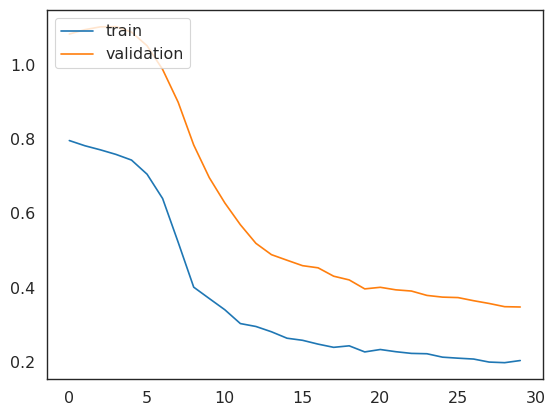

Model: "sequential_42"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_126 (LSTM)             (None, 1, 128)            71168     
                                                                 
 dropout_126 (Dropout)       (None, 1, 128)            0         
                                                                 
 lstm_127 (LSTM)             (None, 1, 64)             49408     
                                                                 
 dropout_127 (Dropout)       (None, 1, 64)             0         
                                                                 
 lstm_128 (LSTM)             (None, 32)                12416     
                                                                 
 dropout_128 (Dropout)       (None, 32)                0         
                                                                 
 dense_42 (Dense)            (None, 1)               

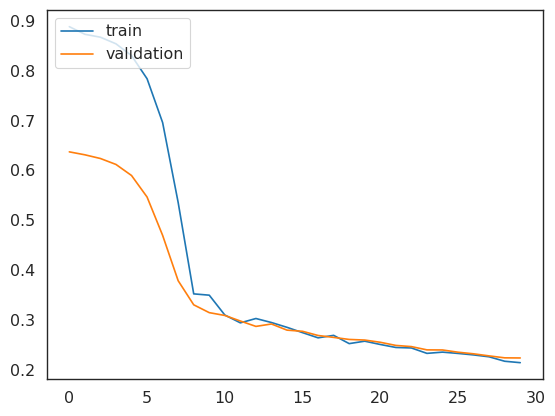

Model: "sequential_43"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_129 (LSTM)             (None, 1, 128)            71168     
                                                                 
 dropout_129 (Dropout)       (None, 1, 128)            0         
                                                                 
 lstm_130 (LSTM)             (None, 1, 64)             49408     
                                                                 
 dropout_130 (Dropout)       (None, 1, 64)             0         
                                                                 
 lstm_131 (LSTM)             (None, 32)                12416     
                                                                 
 dropout_131 (Dropout)       (None, 32)                0         
                                                                 
 dense_43 (Dense)            (None, 1)               

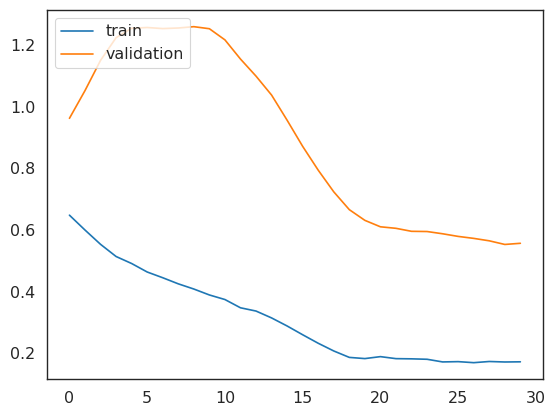

Model: "sequential_44"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_132 (LSTM)             (None, 1, 128)            71168     
                                                                 
 dropout_132 (Dropout)       (None, 1, 128)            0         
                                                                 
 lstm_133 (LSTM)             (None, 1, 64)             49408     
                                                                 
 dropout_133 (Dropout)       (None, 1, 64)             0         
                                                                 
 lstm_134 (LSTM)             (None, 32)                12416     
                                                                 
 dropout_134 (Dropout)       (None, 32)                0         
                                                                 
 dense_44 (Dense)            (None, 1)               

In [ ]:
from keras import backend

data = pd.read_csv('stores_sales.csv')
data['date'] = pd.to_datetime(data['date'], dayfirst=True)
store_count = len(main_data.store.value_counts())

def rmse(y_true, y_pred):
    return backend.sqrt(backend.mean(backend.square(y_pred - y_true), axis=-1))

for store in range(1, store_count + 1 ):
  store_data = data[data['store'] == store]
  features_to_scale = ['weekly_sales']
  store_data.set_index('date', inplace=True)
  store_data = store_data.resample("D").interpolate("linear")
  # Fit and transform the selected features
  scaled_data = scaler.fit_transform(store_data[features_to_scale])
  # Convert scaled_data back to a DataFrame
  scaled_df = pd.DataFrame(scaled_data, columns=features_to_scale, index=store_data.index)
  #Lagged Values
  num_lags = 3  # Number of lagged values to consider
  for i in range(1, num_lags + 1):
      scaled_df[f'lag_{i}'] = scaled_df['weekly_sales'].shift(i)
  # Moving Averages
  window = 4  # Moving average window size
  scaled_df['moving_avg'] = scaled_df['weekly_sales'].rolling(window=window).mean()
  # Seasonality Features
  scaled_df['month'] = scaled_df.index.month
  scaled_df['quarter'] = scaled_df.index.quarter
  scaled_df['day_of_week'] = scaled_df.index.dayofweek
  scaled_df['week_of_month'] = scaled_df.index.map(lambda date: (date.day - 1) // 7 + 1)
  scaled_df['week_of_year'] = scaled_df.index.map(lambda date: date.strftime('%U')).astype(int)
  holiday_dates = ['2010-02-12', '2011-02-11', '2012-02-10', '2013-02-08',
                 '2010-09-10', '2011-09-09', '2012-09-07', '2013-09-06',
                 '2010-11-26', '2011-11-25', '2012-11-23', '2013-11-29',
                 '2010-12-31', '2011-12-30', '2012-12-28', '2013-12-27']
  scaled_df['holiday_flag'] = scaled_df.index.isin(holiday_dates).astype(int)
  print("tail", scaled_df.describe())
  #cleaning nan
  scaled_df = scaled_df.dropna()
  #splitting the data
  train_size = int(len(scaled_df) * 0.85)
  test_size = len(scaled_df) - train_size
  train, test = scaled_df[0:train_size], scaled_df[train_size:len(scaled_df)]
  train = train.drop(columns=['weekly_sales'])
  test = test.drop(columns=['weekly_sales'])
  Y_train , Y_test =  scaled_df['weekly_sales'][0:train_size], scaled_df['weekly_sales'][train_size:len(scaled_df)]
  X_train = np.reshape(np.array(train), (train.shape[0],1, train.shape[1]))
  X_test = np.reshape(np.array(test), (test.shape[0],1, test.shape[1]))
  model = Sequential()
  model.add(LSTM(128, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True))
  model.add(Dropout(0.2))
  model.add(LSTM(64, return_sequences=True))
  model.add(Dropout(0.2))
  model.add(LSTM(32))
  model.add(Dropout(0.2))
  model.add(Dense(1))
  model.compile(loss='mean_squared_error', optimizer='adam', metrics=[rmse])
  history = model.fit(X_train, Y_train, epochs=30, batch_size=100, verbose=1, shuffle=False, validation_split=0.2)
  plt.plot(history.history['rmse'])
  plt.plot(history.history['val_rmse'])
  plt.legend(['train', 'validation'], loc='upper left')
  plt.show()
  model.summary()
  model_path = f'models/store_{store}_model.h5'
  model.save(model_path)

# 4. Prediction

Finally, we begin by making predictions for the total sales using a specific date and store number as input. Subsequently, we proceed to disaggregate these predicted values using historical proportions that are characteristic of the given store. This ensures that the distribution of sales aligns with established patterns.

Following this, we employ a store-specific model to forecast sales, thereby refining our predictions based on the distinct characteristics of each store. Once these forecasts are generated, we consolidate the results to calculate the final outcome. This culmination takes into account both the specific date and the unique store number, resulting in a comprehensive and accurate projection of sales.





In [ ]:
from keras.models import load_model
def rmse(y_true, y_pred):
    return backend.sqrt(backend.mean(backend.square(y_pred - y_true), axis=-1))

def load_model_for_store(store_number):
    model_path = f'models/store_{store_number}_model.h5'
    loaded_model = load_model(model_path, compile = False)
    loaded_model.compile(loss='mean_squared_error', optimizer='adam', metrics=[rmse])
    print(loaded_model)
    return loaded_model

def forecast(date, store):
  given_df = pd.DataFrame()
  pd_datetime = pd.to_datetime(date, dayfirst=True)
  given_df['date'] = [pd_datetime]
  given_df['date'] = given_df['date'].apply(lambda x: x.replace(year=2000))
  given_df.set_index('date', inplace=True)
  given_df['weekly_sales'] = [0]
  store_data = data[data['store'] == store]
  features_to_scale = ['weekly_sales']
  store_data.set_index('date', inplace=True)
  store_data = store_data.resample("D").interpolate("linear")
  # Fit and transform the selected features
  scaled_data = scaler.fit_transform(store_data[features_to_scale])
  # Convert scaled_data back to a DataFrame
  scaled_df = pd.DataFrame(scaled_data, columns=features_to_scale, index=store_data.index)
  #Lagged Values
  num_lags = 3  # Number of lagged values to consider
  for i in range(1, num_lags + 1):
      scaled_df[f'lag_{i}'] = scaled_df['weekly_sales'].shift(i)
  # Moving Averages
  window = 4  # Moving average window size
  scaled_df['moving_avg'] = scaled_df['weekly_sales'].rolling(window=window).mean()
  given_df['lag_1'] = [scaled_df['lag_1'].mean()]
  given_df['lag_2'] = [scaled_df['lag_2'].mean()]
  given_df['lag_3'] = [scaled_df['lag_3'].mean()]
  given_df['moving_avg'] = [scaled_df['moving_avg'].mean()]
  given_df['month'] = [pd_datetime.month]
  given_df['quarter'] = [(pd_datetime.month - 1) // 3 + 1]
  given_df['day_of_week'] = [pd_datetime.weekday()]
  holiday_dates = ['2010-02-12', '2011-02-11', '2012-02-10', '2013-02-08',
                 '2010-09-10', '2011-09-09', '2012-09-07', '2013-09-06',
                 '2010-11-26', '2011-11-25', '2012-11-23', '2013-11-29',
                 '2010-12-31', '2011-12-30', '2012-12-28', '2013-12-27']
  holiday_dates = pd.to_datetime(holiday_dates, format='%Y-%m-%d').map(lambda x: x.replace(year=2000))
  given_df['holiday_flag'] = given_df.index.isin(holiday_dates).astype(int)
  given_df['week_of_month'] = given_df.index.map(lambda date: (date.day - 1) // 7 + 1)
  given_df['week_of_year'] = given_df.index.map(lambda date: date.strftime('%U')).astype(int)
  given_df = given_df.drop(columns=['weekly_sales'])
  input_sequence = np.reshape(np.array(given_df), (1, 1, given_df.shape[1]))
  model_path = f'models/overall_model.h5'
  overall_model = load_model(model_path, compile = False)
  overall_model.compile(loss='mean_squared_error', optimizer='adam', metrics=[rmse])
  predicted_scaled_value = overall_model.predict(input_sequence)
  disaggregated_forecasts= predicted_scaled_value * historical_proportions[store]
  model_specific = load_model_for_store(store)
  forecast = model_specific.predict(input_sequence)
  final_forecast = disaggregated_forecasts + forecast
  predicted_scaled_features = np.zeros((1, len(final_forecast)))
  predicted_scaled_features[0, 0] = predicted_scaled_value  # Fill in the predicted value
  predicted_features = scaler.inverse_transform(predicted_scaled_features)
  predicted_weekly_sales = predicted_features[0, 0]
  print("Predicted Weekly Sales:", predicted_weekly_sales)
forecast('08-09-2014',30 )

1/1 [==============================] - 3s 3s/step


1/1 [==============================] - 2s 2s/step
Predicted Weekly Sales: 459175.28958104085



# I. Model Deployment in Production and Continuous Monitoring
When deploying machine learning models into a production environment, continuous monitoring and logging are crucial aspects to ensure reliability and performance. We recommend developing a **REST API** using frameworks like FAST API or Flask. This API will handle various tasks, such as deserializing and validating incoming inputs. Serialization of the trained ML models is also a vital step for seamless integration. To enhance security, consider implementing measures like JSON Web Tokens (JWT).

For effective data management, storing all recorded data in a time series database such as **InfluxDB** is advisable. This database will serve as a repository for the data engineering pipeline, which includes data imputation, feature extraction, feature selection, and data augmentation. Furthermore, this architecture should incorporate the training of machine learning models. Adhering to best practices, **Docker/Docker-compose** can greatly simplify maintenance and scalability. It also allows for the addition of auxiliary services like monitoring tools (e.g., Zabbix), logging mechanisms (starting
from scratch using shell scripts) or specialized Application Performance Monitoring APM tools like Datadog and Load balancing using tools like Nginx ensures optimal distribution of incoming requests.

# II. Model Retraining
To maintain model performance, regular retraining is essential. We recommend leveraging a tool like Jenkins to create and trigger nightly or weekly jobs (It depends to how the data was registred) responsible for retraining and updating the ML models. Storing these updated models in a NoSQL database like MongoDB offers benefits such as improved indexing and security.

# III. Model Improvement
Continuous model improvement is paramount for accurate predictions over time. For LSTM models, we suggest automating parameter tuning. Develop an algorithm that performs a grid search to identify the best parameters during the training cycle. As time progresses, evaluating additional features becomes important. Apply operations like sorting to transform these features into suitable time series formats for forecasting.

Expanding the hierarchical architecture [presented before] to include mult-levels enhances the model's accuracy. While the initial work focused on overall store total sales, consider introducing additional levels to represent other features. Aggregate these features, calculate historical proportions, and then disaggregate them. This more intricate approach requires extra effort and time, but the results it provides are notably more accurate. By considering a broader hierarchy, the model gains the capacity to capture nuances across different levels of data aggregation, leading to refined forecasting outcomes.
